In [23]:
#Import the libraries that we need
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import timm
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm # This is optional but useful
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

emnist_dataset = datasets.EMNIST(root='./', # here
                                split='letters',
                                train=True, # train split
                                download=True, # we want to get the data
                                transform=T.ToTensor(), # put it into tensor format
                              )
train_data = DataLoader(emnist_dataset,
                        batch_size=10,
                        )

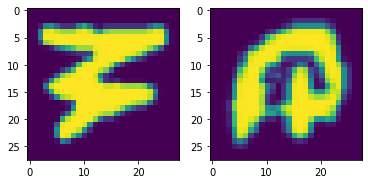

In [118]:
import matplotlib.pyplot as plt
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

In [40]:

class LinearNet(nn.Module):
    def __init__(self,
                 ninputs=1*28*28,
                 nhidden=512,
                 nout=62,
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden, bias=True),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout, bias=True),
            nn.ReLU(),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1)
        x = self.net(x)
        return x

In [113]:
x = torch.randn(3, 1, 28,28)
x = torch.relu(nn.Conv2d(1,6,5,padding=2)(x))
x.shape
x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
x.shape
x= torch.relu(nn.Conv2d(6, 16, 5, padding=0)(x))
x.shape
x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
x.shape

x.shape

torch.Size([3, 16, 5, 5])

In [116]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6,5,padding=2)
        self.conv2 = nn.Conv2d(6,16,5, padding=0)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,62)
        
    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = torch.sigmoid(self.conv2(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)
        
        x = x.view(-1, 5*5*16)
        
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [117]:
# Let's get the right torch device (preference of GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Let's set up some parameters
learning_rate=0.001
nepochs = 5
ninputs=1*28*28
nhidden=1024
nout=62


#model = LinearNet(ninputs=ninputs, nhidden=nhidden, nout=nout).to(device)
model = LeNet().to(device)

print(model)

# We need an optimizer that tells us what form of gradient descent to do
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# We also need a loss function
LossFunction = nn.CrossEntropyLoss()

batch_size = 200

emnist_dataset = datasets.EMNIST(root='./', # here
                                split='byclass',
                                train=True, # train split
                                download=True, # we want to get the data
                                transform=T.ToTensor(), # put it into tensor format
                              )
train_data = DataLoader(emnist_dataset,
                        batch_size=batch_size,
                        )


# This is default on but let's just be pedantic
model.train()
loss_history = []
loss = torch.Tensor([0])
for epoch in tqdm(range(nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)


Epoch:  20%|██████████████▌                                                          | 1/5 [02:46<11:05, 166.30s/epoch]

Epoch 0: loss: 0.5283110737800598


Epoch:  40%|█████████████████████████████▏                                           | 2/5 [05:36<08:22, 167.39s/epoch]

Epoch 1: loss: 0.4336187243461609


Epoch:  60%|███████████████████████████████████████████▊                             | 3/5 [08:36<05:42, 171.32s/epoch]

Epoch 2: loss: 0.39827072620391846


Epoch:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [12:55<03:17, 197.55s/epoch]

Epoch 3: loss: 0.37278345227241516


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [17:21<00:00, 208.27s/epoch]

Epoch 4: loss: 0.35528337955474854


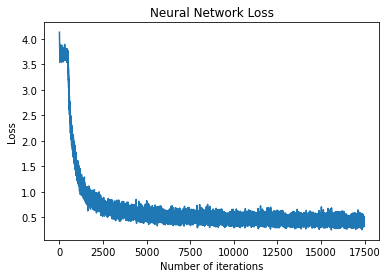

Total accuracy = 84.58%


In [120]:
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

emnist_test_dataset = datasets.EMNIST(root='./', # here
                                split='byclass',
                                train=False, # train split
                                download=True, # we want to get the data
                                transform=T.ToTensor(), # put it into tensor format
                              )
test_data = DataLoader(emnist_test_dataset,
                        batch_size=batch_size,
                        )

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(emnist_test_dataset)*100:.2f}%")

In [ ]:
#Some sources - DON'T DELETE

#https://www.nist.gov/itl/products-and-services/emnist-dataset#:~:text=The%20EMNIST%20Letters%20dataset%20merges,with%20the%20original%20MNIST%20dataset.
#https://pytorch.org/vision/stable/datasets.html#emnist